# 「こころ」でWord2Vec
- コールバックなどの確認

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

In [2]:
import pandas as pd


In [3]:
random_state = 12345

In [4]:
data = pd.read_csv('こころ_形態素.csv', index_col=0)

In [5]:
data

,テキスト,部,章,章（ラベル）,テキスト_形態素
0,私はその人を常に先生と呼んでいた。だからここでもただ先生と書くだけで本名は打ち明けない。こ...,[1]上＿先生と私,1_01,上・一,"['私', 'は', 'その', '人', 'を', '常に', '先生', 'と', '呼..."
1,私が先生と知り合いになったのは鎌倉である。その時私はまだ若々しい書生であった。暑中休暇を利...,[1]上＿先生と私,1_01,上・一,"['私', 'が', '先生', 'と', '知り合い', 'に', 'なる', 'た', ..."
2,学校の授業が始まるにはまだ大分日数があるので鎌倉におってもよし、帰ってもよいという境遇にい...,[1]上＿先生と私,1_01,上・一,"['学校', 'の', '授業', 'が', '始まる', 'に', 'は', 'まだ', ..."
3,宿は鎌倉でも辺鄙な方角にあった。玉突きだのアイスクリームだのというハイカラなものには長い畷...,[1]上＿先生と私,1_01,上・一,"['宿', 'は', '鎌倉', 'で', 'も', '辺鄙', 'だ', '方角', 'に..."
4,私は毎日海へはいりに出掛けた。古い燻ぶり返った藁葺の間を通り抜けて磯へ下りると、この辺にこ...,[1]上＿先生と私,1_01,上・一,"['私', 'は', '毎日', '海', 'へ', 'はいる', 'に', '出掛ける',..."
...,...,...,...,...,...
1210,それから二、三日して、私はとうとう自殺する決心をしたのです。私に乃木さんの死んだ理由がよく...,[3]下＿先生と遺書,3_56,下・五十六,"['それから', '二', '三', '日', 'する', 'て', '私', 'は', '..."
1211,私は妻を残して行きます。私がいなくなっても妻に衣食住の心配がないのは仕合せです。私は妻に残...,[3]下＿先生と遺書,3_56,下・五十六,"['私', 'は', '妻', 'を', '残す', 'て', '行く', 'ます', '私..."
1212,私が死のうと決心してから、もう十日以上になりますが、その大部分はあなたにこの長い自叙伝の一...,[3]下＿先生と遺書,3_56,下・五十六,"['私', 'が', '死ぬ', 'う', 'と', '決心', 'する', 'て', 'か..."
1213,しかし私は今その要求を果たしました。もう何にもする事はありません。この手紙があなたの手に落...,[3]下＿先生と遺書,3_56,下・五十六,"['しかし', '私', 'は', '今', 'その', '要求', 'を', '果たす',..."


In [6]:
word_list = data['テキスト_形態素'].apply(eval)  # str -> list へ変換

In [7]:
word_list = list(word_list)

In [8]:
#word_list

In [9]:
len(word_list)

1215

In [10]:
# Word2Vecライブラリの導入
#!sudo /opt/conda/bin/python -m pip install gensim

In [11]:
# Word2Vecライブラリのロード
from gensim.models import word2vec

In [12]:
# Word2Vec用のCallback
from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self, print_interval=5):
        self.epoch = 0
        self.train_loss = []
        self.print_interval = print_interval

    def on_epoch_begin(self, model):
#        print("Epoch #{} start".format(self.epoch))
        pass

    def on_epoch_end(self, model):
        # Notice:
        #  Current value of get_latest_training_loss seems to be incorrect.
        #  See pull-request below:
        #  Fix computation of `Word2Vec` loss & add loss value to logging string
        #  https://github.com/RaRe-Technologies/gensim/pull/2135
        #
        #  See also:
        #  https://stackoverflow.com/questions/52038651/loss-does-not-decrease-during-training-word2vec-gensim

        _loss = model.get_latest_training_loss()
        self.train_loss.append(_loss)
        if self.epoch % self.print_interval == 0:
            print("Epoch #{} end (Loss: {:,.2f})".format(self.epoch, _loss))
        self.epoch += 1
        

In [13]:
# size: 圧縮次元数
# min_count: 出現頻度の低いものをカットする
# window: 前後の単語を拾う際の窓の広さを決める
# iter: 機械学習の繰り返し回数(デフォルト:5)十分学習できていないときにこの値を調整する
# model.wv.most_similarの結果が1に近いものばかりで、model.dict['wv']のベクトル値が小さい値ばかりの 
# ときは、学習回数が少ないと考えられます。
# その場合、iterの値を大きくして、再度学習を行います。

w2v_params = {
    'size': 100,
    'min_count': 1,
    'window': 15,
    'iter': 200,
    'compute_loss': True,
    'seed': random_state,
}

print_interval = 50
epoch_logger = EpochLogger(print_interval=print_interval)

# 事前準備したword_listを使ってWord2Vecの学習実施
#model = word2vec.Word2Vec(word_list, size=100,min_count=5,window=5,iter=100)
model = word2vec.Word2Vec(word_list, **w2v_params, callbacks=[epoch_logger])


Epoch #0 end (Loss: 68,643.32)
Epoch #50 end (Loss: 2,381,249.00)
Epoch #100 end (Loss: 3,950,300.50)
Epoch #150 end (Loss: 5,215,396.00)


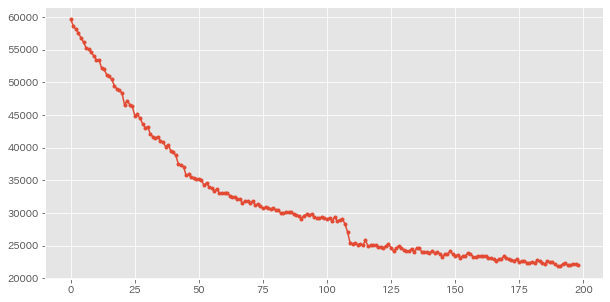

In [14]:
train_loss = np.array(epoch_logger.train_loss)
#train_loss

# Notice:
#  Current value of get_latest_training_loss seems to be incorrect.
#  See pull-request below:
#  Fix computation of `Word2Vec` loss & add loss value to logging string
#  https://github.com/RaRe-Technologies/gensim/pull/2135
#
#  See also:
#  https://stackoverflow.com/questions/52038651/loss-does-not-decrease-during-training-word2vec-gensim
#  (gensim.word2vecのget_latest_training_lossにはバグがあるので、1エポック前との差分で見ないといけない)
diff_loss = train_loss[1:] - train_loss[:-1]  # 1epoch前からの増分

# lossの可視化
plt.figure(figsize=(10, 5))

#X = np.arange(len(train_loss))
#plt.plot(train_loss, marker='.')
plt.plot(diff_loss, marker='.')


In [15]:
# 結果の確認1
# 一つ一つの単語は100次元のベクトルになっています。 
# 「世間」のベクトル値を確認します。
# model.wv['世間'] としてもほぼ同じ
print(model.__dict__['wv']['世間'])

[ 2.0003052   1.3145612   0.05831688  1.2272507   3.0935607  -0.49521077
  1.8190222  -2.42913    -1.6539054  -4.0150523  -1.5147403   3.9093513
  0.32736742 -2.7880633   0.5579745  -0.11362537 -3.094031    0.93140495
  6.2494965  -1.5702231  -4.304531    0.3905624   1.0212245  -0.20535903
 -0.82356936  4.2584767   1.5379912  -2.5872378  -2.7861505   1.1736078
  2.1861193   1.8608577   0.01184895 -4.799336   -3.3432813   1.4846002
  1.6751608  -1.6268708   1.0620188  -2.6818986  -2.3368828   0.78787225
 -0.25201237  1.9719135   0.12488313  0.1969378  -1.1555481  -2.7089252
 -1.4743274   2.01987    -0.12746806 -1.7515712   4.2380295   0.34617496
  2.4712849   0.2586311  -0.18568571  2.464785    0.7778619  -0.7229601
 -0.17561403 -1.4032979   4.2849174  -1.0011743   0.30340356 -1.3041058
 -3.8584127  -1.8381678  -0.13495144  0.8927088  -2.05792    -0.79862094
  0.43355832  0.88912743 -0.5796918   0.1494689  -0.8298171   2.472721
  2.6628323   0.51560557  1.323769   -6.8298697   2.6000834

In [16]:
# 結果の確認2
# 関数most_similarを使って「世間」の類似単語を調べます 
ret = model.wv.most_similar(positive=['世間']) 
for item in ret:
    print(item[0], item[1])

著名 0.37909048795700073
評する 0.36796650290489197
努力 0.3512151837348938
先輩 0.3483651280403137
誰彼 0.3433775305747986
脳髄 0.34194666147232056
暴力 0.3413277268409729
無聊 0.34067344665527344
ひどい 0.3389521837234497
純 0.3384166359901428


In [17]:
ret = model.wv.most_similar(positive=['人間']) 
for item in ret:
    print(item[0], item[1])

悪人 0.38645875453948975
幸福 0.37810593843460083
信愛 0.3404798209667206
犠牲 0.3387081027030945
軽薄 0.33250635862350464
経験 0.3279288113117218
み 0.3247189521789551
よっぽど 0.3236047029495239
変化 0.3227131962776184
憚 0.3103991150856018
